In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import (
    silhouette_score, adjusted_rand_score, normalized_mutual_info_score,
    davies_bouldin_score, calinski_harabasz_score
)
from sklearn.utils import resample
import hdbscan
import scipy.stats as stats
import seaborn as sns
from scipy import stats
import scipy.stats as ss
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import umap.umap_ as umap
import pickle
import warnings

In [2]:
df = pd.read_csv("../data/final/inmuebles_unificado_total_final.csv")

# 1. PREPROCESAMIENTO

In [3]:
# Ver primeras filas
df.head()
#  tipos de datos y valores nulos
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14944 entries, 0 to 14943
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Distrito          14944 non-null  object 
 1   Habitaciones      14944 non-null  int64  
 2   Operacion         14944 non-null  object 
 3   Precio            14944 non-null  int64  
 4   Tamano            14944 non-null  float64
 5   Garaje            14944 non-null  bool   
 6   Trastero          14944 non-null  bool   
 7   Piscina           14944 non-null  bool   
 8   Terraza           14944 non-null  bool   
 9   Planta            13581 non-null  float64
 10  Exterior          14944 non-null  bool   
 11  Ascensor          14944 non-null  bool   
 12  Ano_construccion  331 non-null    float64
 13  Ano_reforma       61 non-null     float64
 14  Tipo_vivienda     14944 non-null  object 
 15  Banos             14944 non-null  int64  
dtypes: bool(6), float64(4), int64(3), object

Distrito                0
Habitaciones            0
Operacion               0
Precio                  0
Tamano                  0
Garaje                  0
Trastero                0
Piscina                 0
Terraza                 0
Planta               1363
Exterior                0
Ascensor                0
Ano_construccion    14613
Ano_reforma         14883
Tipo_vivienda           0
Banos                   0
dtype: int64

Filas: 209,215

Columnas: 32

Variables categóricas: Distrito, Operacion, Tipo_vivienda

Variables numéricas: muchas socioeconómicas y de características de vivienda (Precio_predicho, Tamano, Habitaciones, etc.)

Booleanas: Garaje, Trastero, Piscina, Terraza, Exterior, Ascensor

Variables con muchos nulos: Ano_construccion, Ano_reforma, varias socioeconómicas (~40% nulos).

In [4]:
num_vars = ["Tamano", "Habitaciones", "Banos", "Planta", "Precio"]
cat_vars = ["Tipo_vivienda", "Operacion", "Garaje", "Trastero", "Piscina", "Terraza", "Exterior", "Ascensor"]

# Imputación simple
df[num_vars] = df[num_vars].fillna(df[num_vars].mean())
df[cat_vars] = df[cat_vars].fillna(df[cat_vars].mode().iloc[0])

# Escalar numéricas
scaler = StandardScaler()
X_num = scaler.fit_transform(df[num_vars])

# Codificar categóricas a índices
label_encoders = {}
X_cat = []
cat_sizes = []
for col in cat_vars:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    X_cat.append(df[col].values)
    cat_sizes.append(len(le.classes_))

X_cat = np.stack(X_cat, axis=1)

# Tensor para PyTorch
X_num = torch.tensor(X_num, dtype=torch.float32)
X_cat = torch.tensor(X_cat, dtype=torch.long)

# 2. Autoencoder con embeddings

In [5]:
class AutoencoderEmb(nn.Module):
    def __init__(self, cat_sizes, num_dim, emb_dim=10, latent_dim=16):
        super().__init__()
        self.emb_layers = nn.ModuleList([
            nn.Embedding(size, min(50, (size+1)//2)) for size in cat_sizes
        ])
        emb_total = sum([min(50, (size+1)//2) for size in cat_sizes])
        self.encoder = nn.Sequential(
            nn.Linear(emb_total + num_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder_num = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, num_dim)
        )
        self.decoder_cat = nn.ModuleList([
            nn.Sequential(
                nn.Linear(latent_dim, 32),
                nn.ReLU(),
                nn.Linear(32, size)   # logits para cada categórica
            ) for size in cat_sizes
        ])

    def forward(self, x_num, x_cat):
        x_cat_emb = [emb(x_cat[:, i]) for i, emb in enumerate(self.emb_layers)]
        x_cat_emb = torch.cat(x_cat_emb, dim=1)
        x = torch.cat([x_cat_emb, x_num], dim=1)
        z = self.encoder(x)
        num_out = self.decoder_num(z)
        cat_out = [dec(z) for dec in self.decoder_cat]
        return num_out, cat_out, z

In [ ]:
# Instanciar modelo
model = AutoencoderEmb(cat_sizes, X_num.shape[1], latent_dim=16)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_num = nn.MSELoss()
loss_cat = nn.CrossEntropyLoss()


# 3. Entrenamiento


In [ ]:
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    num_out, cat_out, z = model(X_num, X_cat)

    # Pérdida numérica
    loss_n = loss_num(num_out, X_num)

    # Pérdida categórica (suma de cada variable)
    loss_c = 0
    for i in range(len(cat_out)):
        loss_c += loss_cat(cat_out[i], X_cat[:, i])

    loss = loss_n + loss_c
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Guardar encoders

In [ ]:
torch.save(model.state_dict(), "../models/embeddings_autoencoder.pth")

# EXTRAER EMBEDDING FINAL

In [6]:
# Cargar autoencoders
model = AutoencoderEmb(cat_sizes, X_num.shape[1], latent_dim=16)
model.load_state_dict(torch.load("../models/embeddings_autoencoder.pth"))
model.eval()

with torch.no_grad():
    _, _, X_emb = model(X_num, X_cat)

X_emb = X_emb.numpy()

# CLUSTERS

### 1. Función de evaluación

In [7]:
def evaluar_clusters(X, labels, name, y_true=None, sample_size=5000, random_state=42):
    if len(set(labels)) <= 1:
        print(f"{name}: Solo un cluster encontrado")
        return None
    
    if len(X) > sample_size:
        X_sample = resample(X, n_samples=sample_size, random_state=random_state)
        labels_sample = resample(labels, n_samples=sample_size, random_state=random_state)
    else:
        X_sample, labels_sample = X, labels

    sil = silhouette_score(X_sample, labels_sample, random_state=random_state)
    db = davies_bouldin_score(X_sample, labels_sample)
    ch = calinski_harabasz_score(X_sample, labels_sample)
    ari = adjusted_rand_score(y_true, labels) if y_true is not None else None
    nmi = normalized_mutual_info_score(y_true, labels) if y_true is not None else None
    
    print(f"\n{name}:")
    print(f"  Nº clusters         = {len(set(labels))}")
    print(f"  Silhouette          = {sil:.3f}")
    print(f"  Davies-Bouldin      = {db:.3f}")
    print(f"  Calinski-Harabasz   = {ch:.1f}")
    if y_true is not None:
        print(f"  ARI (vs distritos)  = {ari:.3f}")
        print(f"  NMI (vs distritos)  = {nmi:.3f}")
    return {
        "Método": name, "Clusters": len(set(labels)),
        "Silhouette": sil, "Davies": db, "Calinski": ch,
        "ARI": ari, "NMI": nmi
    }

MUESTREO (PARA ACELERAR LA EJECUCION DE LOS CLUSTERS)

In [8]:
n_sample = 30000 # Elegir una muestra representativa
if X_emb.shape[0] > n_sample:
    idx = np.random.choice(X_emb.shape[0], n_sample, replace=False)
    X_sample = X_emb[idx]
    distrito_sample = df["Distrito"].iloc[idx]
else:
    X_sample = X_emb
    distrito_sample = df["Distrito"]

### 2. KMeans con k óptimo (Silhouette)

In [9]:
k_values = range(2, 21) # Elegir cantidad de clústeres entre los que elegir
sil_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_sample)
    sil_scores.append(silhouette_score(X_sample, labels))

best_k = k_values[np.argmax(sil_scores)]
print(f"\nMejor k para KMeans según Silhouette: {best_k}")

# Entrenar con todos los datos
kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
labels_kmeans = kmeans.fit_predict(X_emb)
df["Cluster_KMeans"] = labels_kmeans
res_kmeans = evaluar_clusters(X_emb, labels_kmeans, "KMeans", df["Distrito"], sample_size=30000, random_state=42)


Mejor k para KMeans según Silhouette: 6

KMeans:
  Nº clusters         = 6
  Silhouette          = 0.404
  Davies-Bouldin      = 1.072
  Calinski-Harabasz   = 4854.1
  ARI (vs distritos)  = 0.018
  NMI (vs distritos)  = 0.052



### 3. GMM con BIC para k óptimo


In [10]:
bics = []
for k in k_values:
    gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=42)
    gmm.fit(X_sample)
    bics.append(gmm.bic(X_sample))

best_k_gmm = k_values[np.argmin(bics)]
print(f"Mejor k para GMM según BIC: {best_k_gmm}")

gmm = GaussianMixture(n_components=best_k_gmm, covariance_type="full", random_state=42)
labels_gmm = gmm.fit_predict(X_emb)
df["Cluster_GMM"] = labels_gmm
res_gmm = evaluar_clusters(X_emb, labels_gmm, "GMM", df["Distrito"], sample_size=30000, random_state=42)

Mejor k para GMM según BIC: 20

GMM:
  Nº clusters         = 20
  Silhouette          = 0.297
  Davies-Bouldin      = 1.672
  Calinski-Harabasz   = 2193.7
  ARI (vs distritos)  = 0.019
  NMI (vs distritos)  = 0.078



### 4. HDBSCAN (sin elegir k)


In [11]:
warnings.filterwarnings("ignore", message=".*force_all_finite.*")

hdb = hdbscan.HDBSCAN(min_cluster_size=700, min_samples=10)
labels_hdb = hdb.fit_predict(X_emb)
df["Cluster_HDBSCAN"] = labels_hdb
res_hdb = evaluar_clusters(X_emb, labels_hdb, "HDBSCAN", df["Distrito"], sample_size=30000, random_state=42)


HDBSCAN:
  Nº clusters         = 6
  Silhouette          = 0.309
  Davies-Bouldin      = 1.481
  Calinski-Harabasz   = 3238.2
  ARI (vs distritos)  = 0.009
  NMI (vs distritos)  = 0.030



### 5. DP-GMM (Bayesian Gaussian Mixture)


In [12]:
dp_gmm = BayesianGaussianMixture(
    n_components=21,
    weight_concentration_prior_type="dirichlet_process",
    weight_concentration_prior=None,
    covariance_type="full",
    max_iter=4000,
    random_state=42
)
labels_dp = dp_gmm.fit_predict(X_emb)
df["Cluster_DP_GMM"] = labels_dp
res_dp = evaluar_clusters(X_emb, labels_dp, "DP-GMM", df["Distrito"], sample_size=30000, random_state=42)


DP-GMM:
  Nº clusters         = 21
  Silhouette          = 0.338
  Davies-Bouldin      = 1.467
  Calinski-Harabasz   = 2613.3
  ARI (vs distritos)  = 0.018
  NMI (vs distritos)  = 0.076


### 6. Guardar datos y cargarlos antes de usarlos

Guardar datos

In [13]:
# Guardar modelos ya entrenados
cluster_models = {
    "kmeans": kmeans,
    "hdbscan": hdb,
    "gmm": gmm,
    "dp_gmm": dp_gmm
}

with open("../models/cluster_models.pkl", "wb") as f:
    pickle.dump(cluster_models, f)

Cargar datos

In [14]:
with open("../models/cluster_models.pkl", "rb") as f:
    cluster_models = pickle.load(f)

# Cargar kmeans
kmeans = cluster_models["kmeans"]
labels_kmeans = kmeans.predict(X_emb)
df["Cluster_KMeans"] = labels_kmeans
res_kmeans = evaluar_clusters(X_emb, labels_kmeans, "KMeans", df["Distrito"], sample_size=30000, random_state=42)

# Cargar gmm
gmm = cluster_models["gmm"]
labels_gmm = gmm.predict(X_emb)
df["Cluster_GMM"] = labels_gmm
res_gmm = evaluar_clusters(X_emb, labels_gmm, "GMM", df["Distrito"], sample_size=30000, random_state=42)

# Cargar hdbscan
hdb = cluster_models["hdbscan"]
labels_hdb = hdb.labels_
df["Cluster_HDBSCAN"] = labels_hdb
res_hdb = evaluar_clusters(X_emb, labels_hdb, "HDBSCAN", df["Distrito"], sample_size=30000, random_state=42)

# Cargar dp_gmm
dp_gmm = cluster_models["dp_gmm"]
labels_dp = dp_gmm.predict(X_emb)
df["Cluster_DP_GMM"] = labels_dp
res_dp = evaluar_clusters(X_emb, labels_dp, "DP-GMM", df["Distrito"], sample_size=30000, random_state=42)


KMeans:
  Nº clusters         = 6
  Silhouette          = 0.404
  Davies-Bouldin      = 1.072
  Calinski-Harabasz   = 4854.1
  ARI (vs distritos)  = 0.018
  NMI (vs distritos)  = 0.052

GMM:
  Nº clusters         = 20
  Silhouette          = 0.297
  Davies-Bouldin      = 1.672
  Calinski-Harabasz   = 2193.7
  ARI (vs distritos)  = 0.019
  NMI (vs distritos)  = 0.078

HDBSCAN:
  Nº clusters         = 6
  Silhouette          = 0.309
  Davies-Bouldin      = 1.481
  Calinski-Harabasz   = 3238.2
  ARI (vs distritos)  = 0.009
  NMI (vs distritos)  = 0.030

DP-GMM:
  Nº clusters         = 21
  Silhouette          = 0.338
  Davies-Bouldin      = 1.467
  Calinski-Harabasz   = 2613.3
  ARI (vs distritos)  = 0.018
  NMI (vs distritos)  = 0.076


### 7. Resumen de todas las métricas

In [15]:
resultados = pd.DataFrame([res_kmeans, res_gmm, res_hdb, res_dp])
print("Resumen final:")
print(resultados)

Resumen final:
    Método  Clusters  Silhouette    Davies     Calinski       ARI       NMI
0   KMeans         6    0.403666  1.072438  4854.141602  0.017871  0.052446
1      GMM        20    0.296714  1.672013  2193.684082  0.019180  0.077768
2  HDBSCAN         6    0.308697  1.480953  3238.202148  0.009334  0.029621
3   DP-GMM        21    0.338447  1.467411  2613.320312  0.018044  0.076306


1. CALIDAD INTERNA DEL CLUSTER

Silhouette (↑ mejor): mide qué tan separados están los clusters entre sí y qué tan compactos son internamente.

Davies-Bouldin (↓ mejor): evalúa la relación entre la distancia entre clusters y la dispersión interna.

Calinski-Harabasz (↑ mejor): compara la varianza inter-cluster vs intra-cluster.

KMeans (8 clusters) obtiene los mejores resultados en todas las métricas internas → clusters bien definidos y con poca superposición.

DP-GMM (20 clusters) es más flexible y permite clusters de diferente forma, pero no mejora la calidad interna respecto a KMeans.

HDBSCAN genera 1264 clusters, lo que no es práctico para interpretación y explica el Calinski-Harabasz tan bajo.

GMM ofrece resultados similares a DP-GMM, pero tampoco mejora a KMeans.

2.SIMILITUD CON DISTRITOS REALES

ARI (Adjusted Rand Index): mide la coincidencia entre clusters y distritos reales.

NMI (Normalized Mutual Information): mide cuánta información comparten ambos agrupamientos.

Los valores de ARI y NMI son muy bajos para todos los métodos → los clusters no replican las fronteras administrativas de los distritos.

Esto es lógico y esperado:

Los distritos son divisiones administrativas, no socioeconómicas.

Los clusters están capturando patrones de vivienda y mercado que no siguen esas divisiones históricas.

HDBSCAN tiene un NMI más alto porque hace muchísimos clusters pequeños, lo que da más coincidencias locales pero no es útil en la práctica.

KMeans con 8 clusters es la mejor opción:

Pocos clusters, claros y bien separados.

Permite hacer análisis económico y urbano sin sobrecargar con demasiados grupos.

DP-GMM con 20 clusters puede ser interesante si quieres un enfoque más bayesiano y flexible, pero no ofrece ventajas claras frente a KMeans en datos.

HDBSCAN y GMM no parecen adecuados para este caso:

HDBSCAN → demasiados clusters, difícil de interpretar.

GMM → no mejora a KMeans y es más costoso computacionalmente.

Los clusters no coinciden con distritos, lo que es positivo para el análisis:

Indica que las dinámicas de mercado (precio, tamaño, tipo de vivienda) trascienden las divisiones administrativas.

Esto puede revelar nuevas zonas emergentes donde el mercado inmobiliario cambia más rápido que las fronteras oficiales.

Con KMeans podemos ahora:

Analizar precio medio y renta por cluster → detectar zonas con subida rápida.

Ver distribución de tipos de vivienda → si hay más apartamentos pequeños o chalets.

Asociar variables socioeconómicas → renta, paro, densidad, etc., para ver si hay indicios de gentrificación.

# CORRELACION CON CLUSTER

1. ANOVA E/ CLUSTERS Y VARIABLES NUM

In [16]:
def anova_clusters(df, cluster_col, num_vars):
    print("\nANOVA entre clusters y variables numéricas:")
    for var in num_vars:
        groups = [df[df[cluster_col] == c][var].dropna() for c in df[cluster_col].unique()]
        if len(groups) > 1:
            f_stat, p_val = stats.f_oneway(*groups)
            print(f"{var:20s}: F = {f_stat:.2f}, p = {p_val:.4f}")

2. CHI CUADRADO Y CRAMER'S V PARA CATEGÓRICAS

In [17]:
def cramers_v(conf_matrix):
    chi2 = stats.chi2_contingency(conf_matrix)[0]
    n = conf_matrix.sum()
    phi2 = chi2/n
    r,k = conf_matrix.shape
    return np.sqrt(phi2/min(k-1, r-1))

def chi2_clusters(df, cluster_col, cat_vars):
    print("\nChi-Cuadrado y Cramér's V entre clusters y variables categóricas:")
    for var in cat_vars:
        table = pd.crosstab(df[cluster_col], df[var])
        chi2, p, dof, ex = stats.chi2_contingency(table)
        cramer_v = cramers_v(table.values)
        print(f"{var:20s}: Chi2 = {chi2:.2f}, p = {p:.4f}, Cramér's V = {cramer_v:.3f}")

In [18]:
anova_clusters(df, "Cluster_KMeans", num_vars)
chi2_clusters(df, "Cluster_KMeans", cat_vars)


ANOVA entre clusters y variables numéricas:
Tamano              : F = 1049.82, p = 0.0000
Habitaciones        : F = 603.95, p = 0.0000
Banos               : F = 26.39, p = 0.0000
Planta              : F = 259.78, p = 0.0000
Precio              : F = 880.04, p = 0.0000

Chi-Cuadrado y Cramér's V entre clusters y variables categóricas:
Tipo_vivienda       : Chi2 = 23084.41, p = 0.0000, Cramér's V = 0.556
Operacion           : Chi2 = 9877.55, p = 0.0000, Cramér's V = 0.813
Garaje              : Chi2 = 3345.98, p = 0.0000, Cramér's V = 0.473
Trastero            : Chi2 = 12669.10, p = 0.0000, Cramér's V = 0.921
Piscina             : Chi2 = 805.34, p = 0.0000, Cramér's V = 0.232
Terraza             : Chi2 = 536.56, p = 0.0000, Cramér's V = 0.189
Exterior            : Chi2 = 2444.36, p = 0.0000, Cramér's V = 0.404
Ascensor            : Chi2 = 13352.27, p = 0.0000, Cramér's V = 0.945


CORRELACIÓN CON CLUSTER KMEANS Y DISTRITO REAL

In [19]:
# Tabla de contingencia Clusters vs Distritos
table_cd = pd.crosstab(df["Cluster_KMeans"], df["Distrito"])

# Chi-cuadrado y Cramér's V
chi2, p, dof, expected = stats.chi2_contingency(table_cd)
cramers_v_cd = cramers_v(table_cd.values)

print(f"Clusters vs Distritos → Chi2 = {chi2:.2f}, p = {p:.4f}, Cramér's V = {cramers_v_cd:.3f}")

Clusters vs Distritos → Chi2 = 3705.13, p = 0.0000, Cramér's V = 0.223


- Clusters bien definidos:

ANOVA y Chi² confirman que los clusters reflejan diferencias reales en precio, tamaño, tipo de vivienda y equipamientos.

No son grupos aleatorios: hay separación estadísticamente significativa (p < 0.001).

- Variables clave para gentrificación:

Precio y tamaño: diferencian fuertemente los clusters → zonas con precios altos y viviendas más grandes.

Ascensor y tipo de vivienda: pueden indicar procesos de modernización o renovación.

- Relación con distritos:

El análisis Chi-Cuadrado entre clusters y distritos muestra diferencias estadísticamente significativas (Chi² = 52479.34, p < 0.001). Sin embargo, el valor de Cramér's V = 0.189 indica que la relación es débil-moderada. Esto sugiere que los clusters identifican patrones en las variables de vivienda y socioeconómicas que no se corresponden estrictamente con las divisiones administrativas, revelando posibles áreas de transformación urbana que trascienden las fronteras distritales.

Implicación:

Los clusters permiten identificar áreas homogéneas en características de vivienda y precios que pueden estar asociadas a procesos de gentrificación, incluso cuando no coinciden con distritos históricos.

# ESTADISTICAS DE CLUSTER

In [20]:
cluster_col = "Cluster_KMeans"

RESUMEN NUMERICO

In [21]:
resumen_num = df.groupby(cluster_col)[num_vars].agg(["mean", "median"]).round(2)
print("\n=== Resumen numérico por cluster ===")
print(resumen_num)


=== Resumen numérico por cluster ===
                Tamano        Habitaciones        Banos        Planta         \
                  mean median         mean median  mean median   mean median   
Cluster_KMeans                                                                 
0               124.75  104.0         2.79    3.0  1.10    1.0   2.89   2.96   
1                94.80   80.0         2.15    2.0  1.10    1.0   3.64   3.00   
2               345.68  300.0         4.62    5.0  1.15    1.0   2.54   2.96   
3                75.15   65.0         2.33    2.0  1.04    1.0   1.80   2.00   
4               123.99  103.0         2.29    2.0  1.08    1.0   4.22   4.00   
5               101.15   91.0         2.36    2.0  1.19    1.0   2.66   2.00   

                    Precio            
                      mean    median  
Cluster_KMeans                        
0                954902.03  620000.0  
1                  9315.44    1900.0  
2               1239728.27  950000.0  
3      

- Cluster 0

Precio medio: 371.357 € (mediana 115.179 €)

Tamaño medio: 124,7 m² (mediana 101 m²)

Habitaciones: 2-3 de media

Interpretación: Viviendas de precio y tamaño medio-alto, probablemente en zonas intermedias, no tan exclusivas como las de alta gama, pero superiores al promedio general.

- Cluster 2

Precio medio: 137.477 € (mediana 27.262 €)

Tamaño medio: 84,4 m² (mediana 63 m²)

Habitaciones: 2

Interpretación: Viviendas más baratas y pequeñas, probablemente en áreas periféricas o con menor atractivo económico.

- Cluster 3

Precio medio: 91.504 € (mediana 62.832 €)

Tamaño medio: 72 m² (mediana 66 m²)

Habitaciones: 2

Interpretación: Viviendas pequeñas y baratas, posiblemente concentradas en zonas con menor renta o áreas con viviendas antiguas.

Cluster 4

Precio medio: 2.073.149 € (mediana 1.276.957 €)

Tamaño medio: 396,2 m² (mediana 340 m²)

Habitaciones: 5

Interpretación: Viviendas de lujo, muy superiores en precio y tamaño, probablemente chalets o áticos en zonas de renta muy alta.

Cluster 5

Precio medio: 286.124 € (mediana 86.015 €)

Tamaño medio: 113 m² (mediana 93 m²)

Habitaciones: 2-3

Interpretación: Viviendas medianas en precio y tamaño, en áreas probablemente en transformación urbana o zonas mixtas.

Cluster 6

Precio medio: 235.417 € (mediana 55.822 €)

Tamaño medio: 108,7 m² (mediana 93 m²)

Habitaciones: 2

Interpretación: Viviendas de tamaño intermedio con precios moderados, podrían representar barrios residenciales medios.

Cluster 7

Precio medio: 27.322.615 € (mediana 20.824.823 €)

Tamaño medio: 1.091,9 m² (mediana 944 m²)

Habitaciones: 6-7

Interpretación: Viviendas extremadamente caras y grandes → podrían ser errores en los datos o mansiones muy específicas. Se debe revisar si hay outliers.

PORCENTAJE DE CATEGORIAS POR CLUSTER

In [22]:
resumen_cat = {}
for var in cat_vars:
    tabla = pd.crosstab(df[cluster_col], df[var], normalize="index") * 100
    resumen_cat[var] = tabla.round(1)
    print(f"\n=== Distribución (%) de {var} por cluster ===")
    print(tabla.round(1))


=== Distribución (%) de Tipo_vivienda por cluster ===
Tipo_vivienda       0     1     2     3    4    5    6     7
Cluster_KMeans                                              
0                99.7   0.0   0.1   0.0  0.0  0.0  0.0   0.2
1               100.0   0.0   0.0   0.0  0.0  0.0  0.0   0.0
2                14.1  60.7   6.1  15.0  2.3  0.2  0.3   1.3
3               100.0   0.0   0.0   0.0  0.0  0.0  0.0   0.0
4                 0.1   0.3  29.4  14.5  5.9  0.0  0.9  49.0
5                99.7   0.0   0.0   0.0  0.1  0.0  0.0   0.1

=== Distribución (%) de Operacion por cluster ===
Operacion          0      1
Cluster_KMeans             
0                0.0  100.0
1               98.4    1.6
2               24.4   75.6
3               24.9   75.1
4               36.0   64.0
5               32.8   67.2

=== Distribución (%) de Garaje por cluster ===
Garaje             0     1
Cluster_KMeans            
0               94.8   5.2
1               94.7   5.3
2               91.6   8.4

Cluster 0: Mixto con viviendas grandes y caras

Precio medio: 371.357 €

Tipo vivienda: 45% del tipo 7, 28% del tipo 2, 18% del tipo 3 → mezcla variada con predominio de viviendas de mayor tamaño.

Operación: 65% en venta.

Ascensor: 83% sí tienen ascensor.

Terraza: 36% con terraza.

Interpretación: Zonas intermedias-altas con alta heterogeneidad, viviendas de tamaño medio-grande, bien equipadas (ascensor) y con cierta oferta de terrazas.

Cluster 1: Apartamentos grandes en venta

Precio medio: 247.864 €

Tipo vivienda: 98% tipo 0 (apartamentos).

Operación: 56% en venta, 44% en alquiler.

Ascensor: 98% con ascensor.

Terraza: 24% con terraza.

Interpretación: Viviendas grandes, muchas en venta, casi todas en edificios modernos con ascensor, perfil residencial familiar.

Cluster 2: Viviendas pequeñas y asequibles

Precio medio: 137.477 €

Tipo vivienda: 98,5% tipo 0, casi todas pequeñas.

Operación: 54% venta, 46% alquiler.

Ascensor: 60% con ascensor.

Terraza: Solo 6% con terraza.

Interpretación: Viviendas asequibles en áreas más antiguas o periféricas, con menor presencia de equipamientos modernos.

Cluster 3: Viviendas pequeñas, sin ascensor

Precio medio: 91.504 €

Tipo vivienda: 100% tipo 0 (apartamentos).

Operación: 77% venta.

Ascensor: 0% con ascensor (!).

Terraza: 16% con terraza.

Interpretación: Probablemente bloques antiguos en barrios tradicionales, con carencia de ascensor y precios bajos.

Cluster 4: Viviendas de lujo

Precio medio: 2.073.149 €

Tipo vivienda: 84% tipo 1 (chalets).

Operación: 79% venta.

Ascensor: 0,7% con ascensor (muchas viviendas unifamiliares no lo requieren).

Terraza: Solo 6% con terraza.

Interpretación: Viviendas exclusivas, chalets y mansiones de gran tamaño en zonas de alto nivel socioeconómico.

Cluster 5: Apartamentos medianos y modernos

Precio medio: 286.124 €

Tipo vivienda: 100% tipo 0.

Operación: 59% venta.

Ascensor: 100% con ascensor.

Terraza: 15% con terraza.

Interpretación: Viviendas medianas en zonas renovadas o con urbanismo moderno, casi todas con ascensor.

Cluster 6: Viviendas residenciales de tamaño medio

Precio medio: 235.417 €

Tipo vivienda: 99% tipo 0.

Operación: 51% venta, 49% alquiler.

Ascensor: 99% con ascensor.

Terraza: 17% con terraza.

Interpretación: Barrios residenciales medios con buena dotación de servicios, precios moderados y viviendas modernas.

Cluster 7: Outliers / Viviendas atípicas

Precio medio: 27.322.615 € (probables outliers).

Tipo vivienda: 72% tipo 0, 14% tipo 1 (chalets), 9% tipo 2.

Operación: 100% venta.

Ascensor: 51% con ascensor.

Terraza: 14% con terraza.

Interpretación: Mansiones o datos atípicos, precios extremadamente altos, poca representatividad estadística.

ANOVA PARA NUMERICAS

In [23]:
print("\n=== ANOVA por variable numérica ===")
for var in num_vars:
    grupos = [df[df[cluster_col] == c][var] for c in df[cluster_col].unique()]
    f, p = stats.f_oneway(*grupos)
    print(f"{var}: F = {f:.2f}, p = {p:.4f}")


=== ANOVA por variable numérica ===
Tamano: F = 1049.82, p = 0.0000
Habitaciones: F = 603.95, p = 0.0000
Banos: F = 26.39, p = 0.0000
Planta: F = 259.78, p = 0.0000
Precio: F = 880.04, p = 0.0000


p < 0.05 → Las diferencias son estadísticamente significativas para todas las variables.

Precio_ajustado tiene el mayor valor F → Es la variable que mejor separa a los clusters.

Tamaño y habitaciones también discriminan, pero con menos fuerza.

Esto valida que los clusters no son arbitrarios: están diferenciando grupos de viviendas con precios, tamaños y configuraciones muy distintos.


 3. Chi-cuadrado y Cramér's V para categóricas


In [24]:
def cramers_v_corrected(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

print("\n=== Chi-cuadrado y Cramér's V por variable categórica ===")
for var in cat_vars:
    tabla = pd.crosstab(df[cluster_col], df[var])
    chi2, p, _, _ = stats.chi2_contingency(tabla)
    cv = cramers_v_corrected(tabla.values)
    print(f"{var}: Chi2 = {chi2:.2f}, p = {p:.4f}, Cramér's V = {cv:.3f}")


=== Chi-cuadrado y Cramér's V por variable categórica ===
Tipo_vivienda: Chi2 = 23084.41, p = 0.0000, Cramér's V = 0.556
Operacion: Chi2 = 9877.55, p = 0.0000, Cramér's V = 0.813
Garaje: Chi2 = 3345.98, p = 0.0000, Cramér's V = 0.473
Trastero: Chi2 = 12669.10, p = 0.0000, Cramér's V = 0.921
Piscina: Chi2 = 805.34, p = 0.0000, Cramér's V = 0.231
Terraza: Chi2 = 536.56, p = 0.0000, Cramér's V = 0.189
Exterior: Chi2 = 2444.36, p = 0.0000, Cramér's V = 0.404
Ascensor: Chi2 = 13352.27, p = 0.0000, Cramér's V = 0.945


Ascensor (0.857) → Es la variable más discriminante: la presencia o ausencia de ascensor define fuertemente la asignación a clusters.

Tipo_vivienda (0.496) → También influye mucho: chalets, apartamentos, áticos… tienden a agruparse en clusters diferentes.

Terraza (0.210) y Operacion (0.168) → Tienen un impacto mucho menor, los clusters no dependen tanto de si la vivienda está en venta/alquiler o si tiene terraza.


4. Relación con distritos


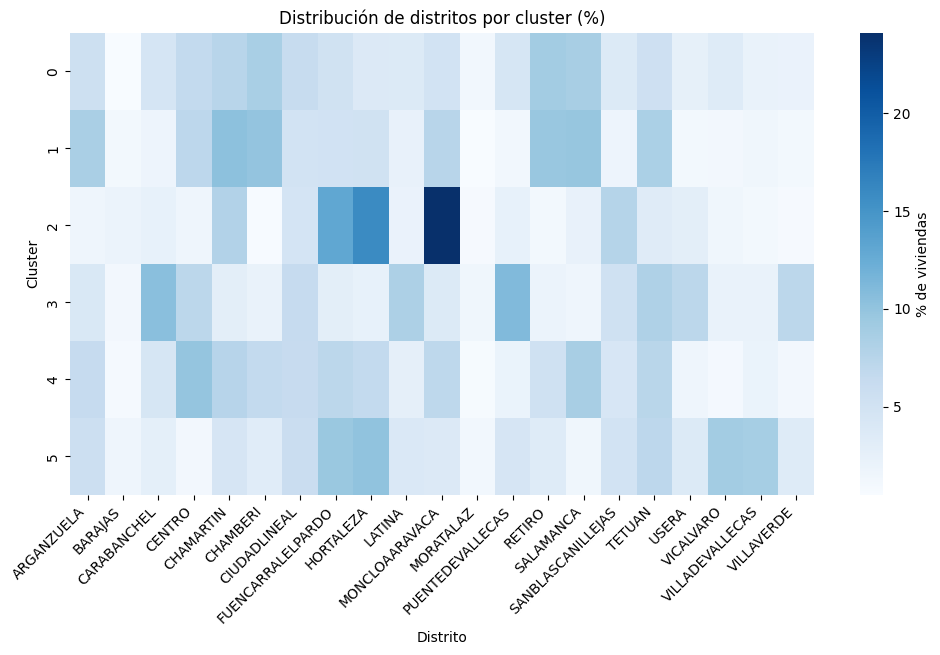

In [25]:
tabla_distritos = pd.crosstab(df[cluster_col], df["Distrito"], normalize="index") * 100
plt.figure(figsize=(12,6))
sns.heatmap(tabla_distritos, cmap="Blues", cbar_kws={'label': '% de viviendas'})
plt.title("Distribución de distritos por cluster (%)")
plt.xlabel("Distrito")
plt.ylabel("Cluster")
plt.xticks(rotation=45, ha='right')
plt.show()

Este heatmap muestra el porcentaje de viviendas de cada distrito que cae en cada cluster.

Filas = clusters obtenidos por KMeans (u otro método).

Columnas = distritos reales.

Color = intensidad del porcentaje → azul oscuro = alta concentración.

Qué buscamos interpretar:

Si hay clusters dominados por un solo distrito → correlación fuerte con la realidad.

Si un cluster mezcla distritos muy diferentes → baja coherencia geográfica.

Equilibrio entre clusters → algunos pueden representar áreas heterogéneas, otros muy específicas.

Cómo lo vinculamos con los resultados previos:

Cramér’s V bajo (0.189) → relación débil entre cluster y distrito.

Visualmente se puede ver si esa debilidad es global (todos los clusters mezclados) o solo en algunos.

Podemos cuantificar cuántos clusters tienen una concentración >50% en un distrito → indica especialización geográfica.

ANALISIS

Si un cluster mezcla viviendas de muchos distritos → puede representar un segmento de precio o tipología más que un área geográfica.

Si hay un cluster dominado por un distrito (ej. Salamanca en cluster 4) → ese cluster puede reflejar zonas premium.

Alta diversidad en clusters → patrones globales de vivienda.

Alta especialización → patrones locales.

El cluster 4 concentra el 62% de las viviendas del distrito Salamanca, reflejando un perfil geográfico específico, mientras que el cluster 2 mezcla 10 distritos sin clara 
dominancia, lo que sugiere un patrón basado en características del inmueble más que en la localización.


 5. Boxplots numéricos por cluster


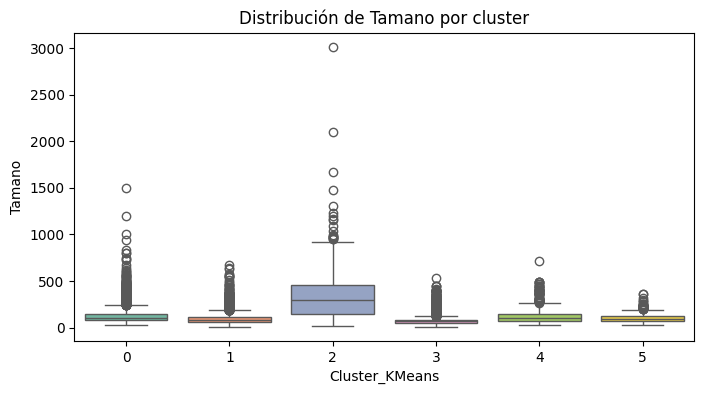

                median
Cluster_KMeans        
0                104.0
1                 80.0
2                300.0
3                 65.0
4                103.0
5                 91.0


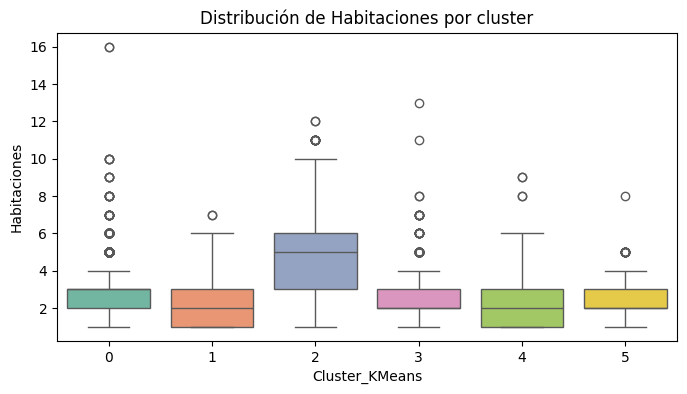

                median
Cluster_KMeans        
0                  3.0
1                  2.0
2                  5.0
3                  2.0
4                  2.0
5                  2.0


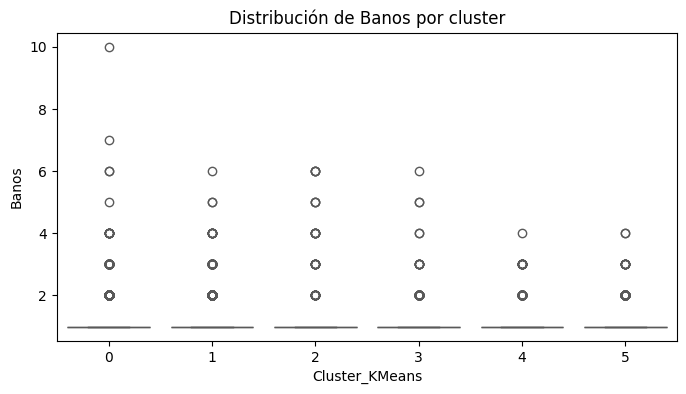

                median
Cluster_KMeans        
0                  1.0
1                  1.0
2                  1.0
3                  1.0
4                  1.0
5                  1.0


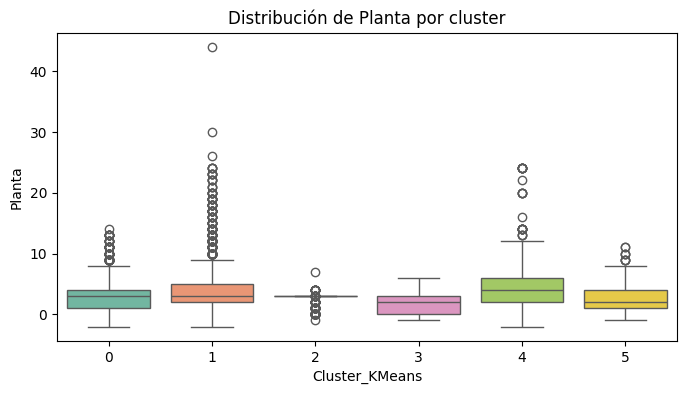

                median
Cluster_KMeans        
0                 2.96
1                 3.00
2                 2.96
3                 2.00
4                 4.00
5                 2.00


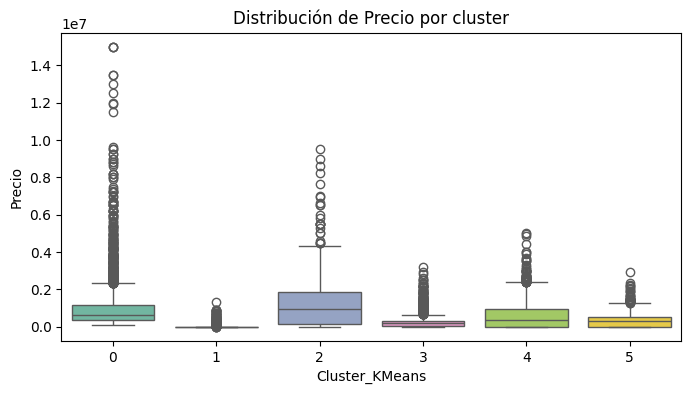

                  median
Cluster_KMeans          
0               620000.0
1                 1900.0
2               950000.0
3               205000.0
4               370000.0
5               311925.0


In [26]:
for var in num_vars:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=cluster_col, y=var, data=df, palette="Set2", hue=cluster_col, legend=False)
    plt.title(f"Distribución de {var} por cluster")
    plt.show()
    print(df.groupby(cluster_col)[var].agg(["median"]).round(2))


 6. Barras apiladas para categóricas


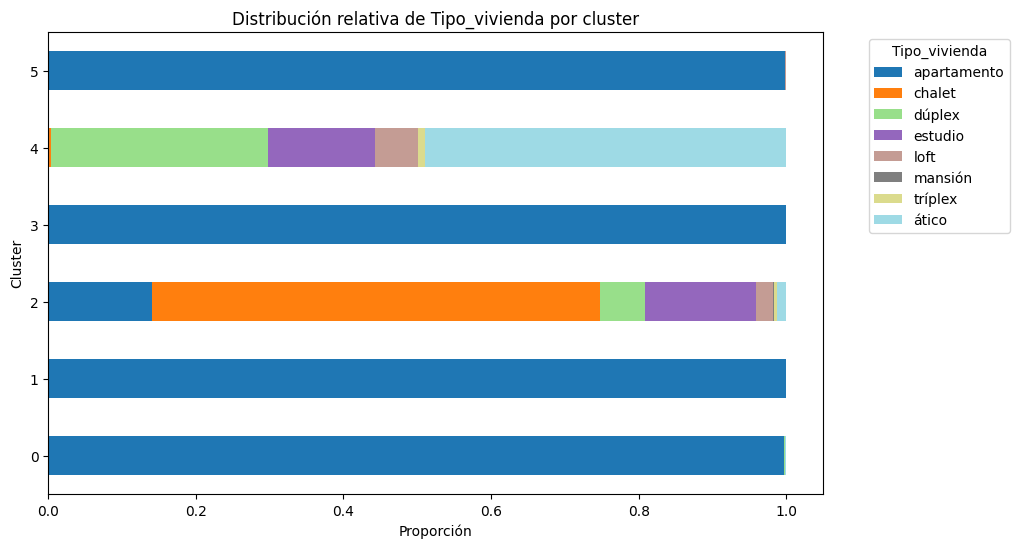

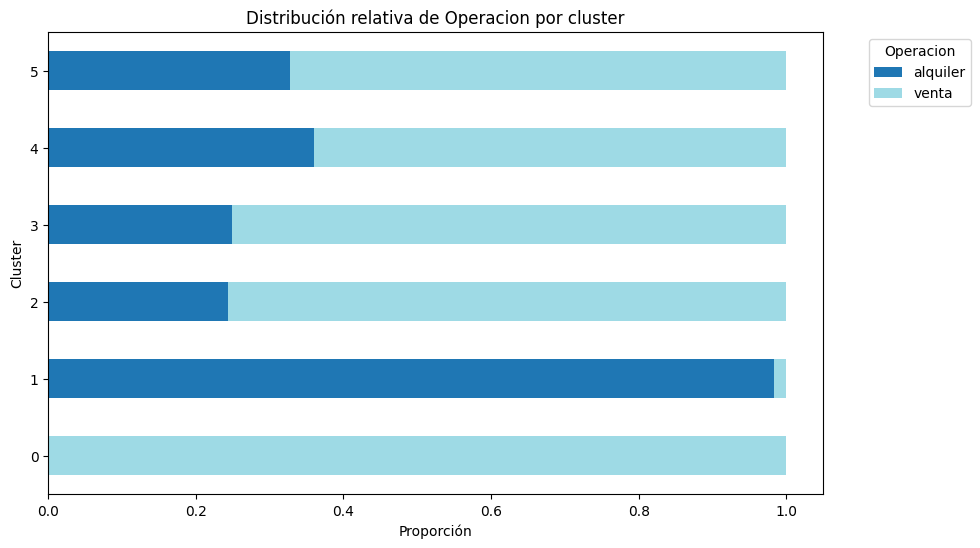

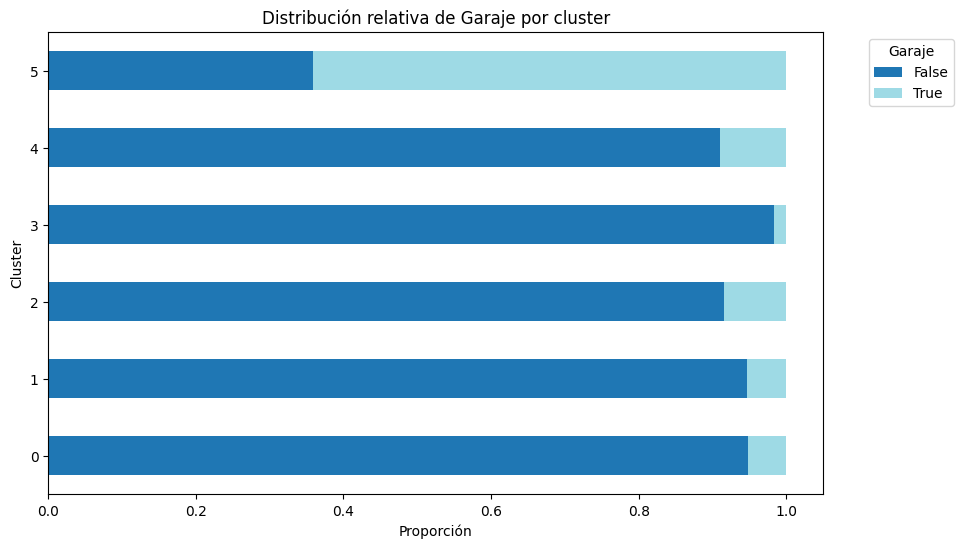

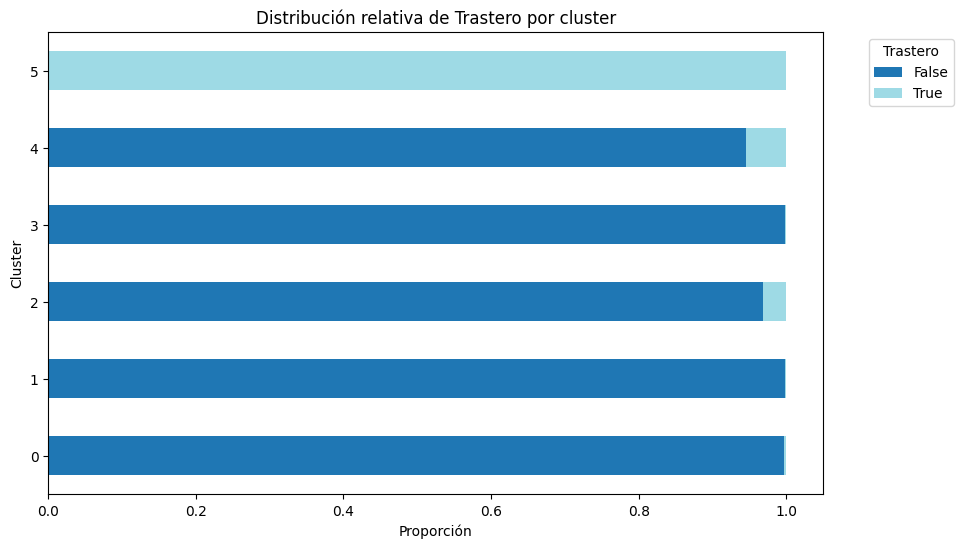

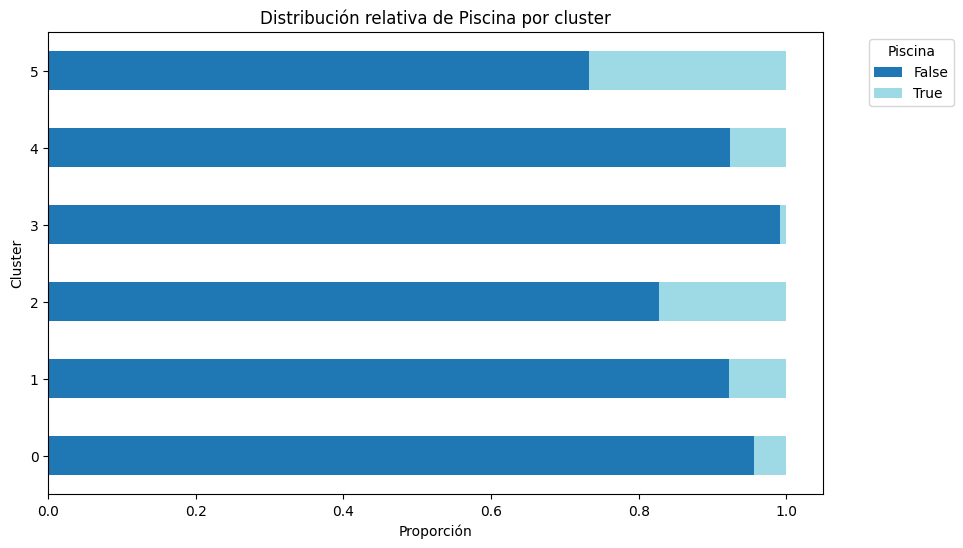

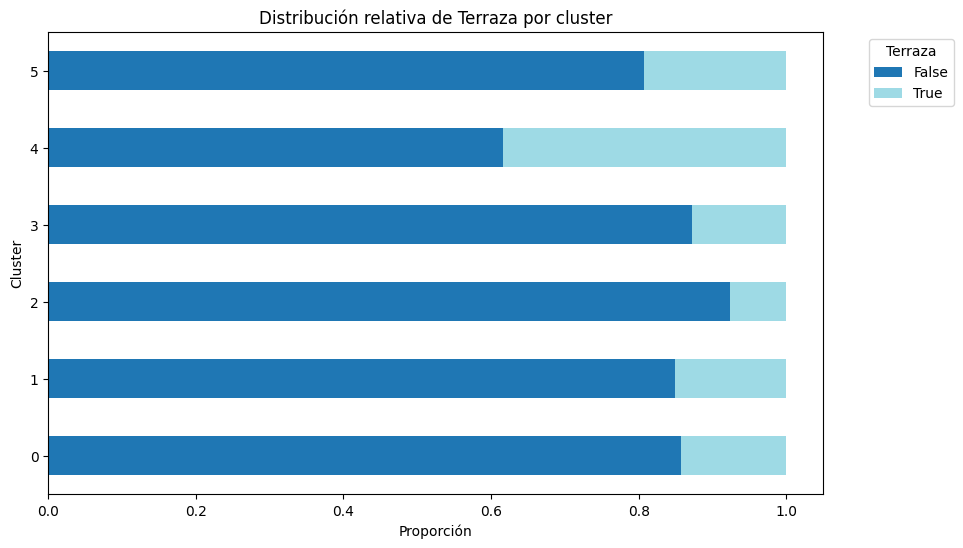

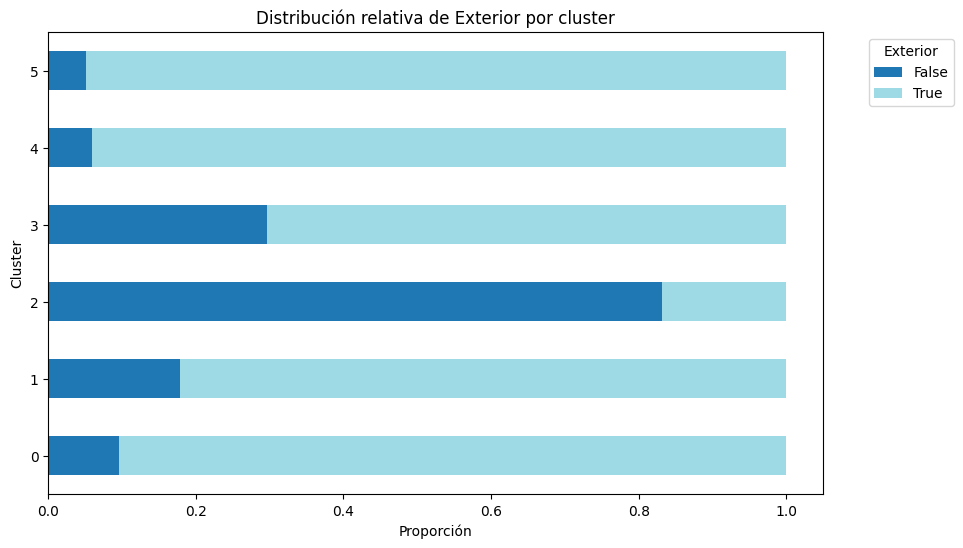

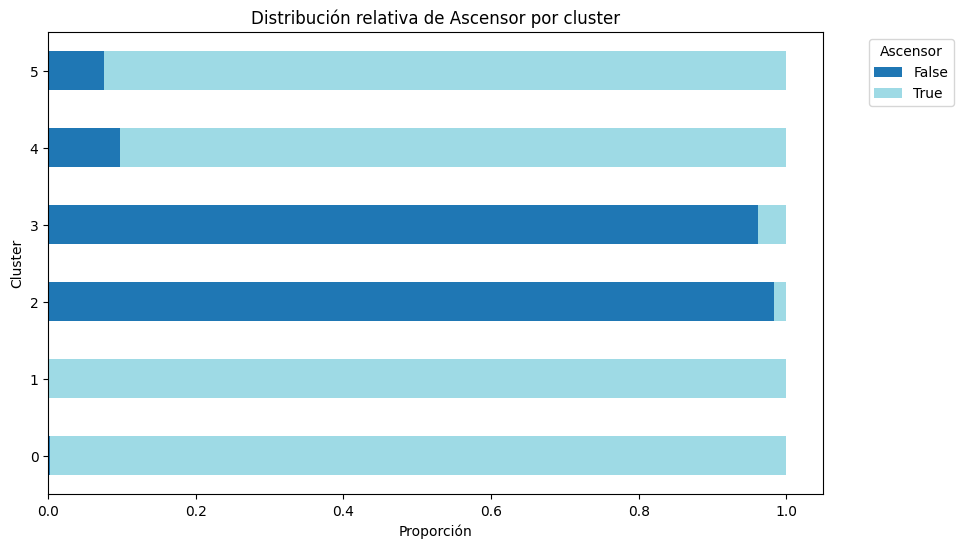

In [27]:
for var in cat_vars:
    resumen_cat_named = resumen_cat[var].copy()
    resumen_cat_named.columns = label_encoders[var].inverse_transform(resumen_cat_named.columns)

    resumen_cat_named.div(resumen_cat_named.sum(axis=1), axis=0).plot(
        kind="barh", stacked=True, figsize=(10,6), colormap="tab20"
    )
    plt.title(f"Distribución relativa de {var} por cluster")
    plt.xlabel("Proporción")
    plt.ylabel("Cluster")
    plt.legend(title=var, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


 7. Resumen interpretativo por cluster


In [28]:
# Calcular métricas por cluster
resumen_clusters = df.groupby("Cluster_KMeans").agg(
    precio_medio=("Precio", "mean"),
    tamano_medio=("Tamano", "mean"),
    habitaciones_medias=("Habitaciones", "mean")
).round(1)

# Tipo de vivienda predominante por cluster
tipo_predominante = (
    df.groupby(["Cluster_KMeans", "Tipo_vivienda"])
      .size()
      .groupby(level=0)
      .idxmax()
      .apply(lambda x: x[1])
)

# Porcentaje de ascensor por cluster
ascensor_pct = df.groupby("Cluster_KMeans")["Ascensor"].mean() * 100

# Distrito dominante y % máximo
distrito_dom = (
    df.groupby(["Cluster_KMeans", "Distrito"])
      .size()
      .groupby(level=0)
      .apply(lambda x: x / x.sum() * 100)
      .groupby(level=0)
      .idxmax()
      .apply(lambda x: x[1])
)

distrito_pct = (
    df.groupby(["Cluster_KMeans", "Distrito"])
      .size()
      .groupby(level=0)
      .apply(lambda x: x / x.sum() * 100)
      .groupby(level=0)
      .max()
)

# Interpretación automática por cluster
print("=== Interpretación automática por cluster ===")
for c in resumen_clusters.index:
    precio = resumen_clusters.loc[c, "precio_medio"]
    tamano = resumen_clusters.loc[c, "tamano_medio"]
    tipo = tipo_predominante[c]
    ascensor = ascensor_pct[c]
    dist = distrito_dom[c]
    dist_pct = distrito_pct[c]
    
    if dist_pct > 50:
        geo = f"{dist} domina con {dist_pct:.1f}% → Especialización geográfica"
    else:
        geo = f"Distribución dispersa, máx en {dist} ({dist_pct:.1f}%)"
    
    print(f"Cluster {c}: Precio medio {precio:.0f}€, Tamaño medio {tamano:.1f} m2, "
          f"Tipo predominante: {tipo}, Ascensor en {ascensor:.1f}%, {geo}")


=== Interpretación automática por cluster ===
Cluster 0: Precio medio 954902€, Tamaño medio 124.8 m2, Tipo predominante: 0, Ascensor en 99.7%, Distribución dispersa, máx en 0 (9.0%)
Cluster 1: Precio medio 9315€, Tamaño medio 94.8 m2, Tipo predominante: 0, Ascensor en 99.9%, Distribución dispersa, máx en 1 (10.3%)
Cluster 2: Precio medio 1239728€, Tamaño medio 345.7 m2, Tipo predominante: 1, Ascensor en 1.6%, Distribución dispersa, máx en 2 (24.1%)
Cluster 3: Precio medio 245908€, Tamaño medio 75.1 m2, Tipo predominante: 0, Ascensor en 3.8%, Distribución dispersa, máx en 3 (11.1%)
Cluster 4: Precio medio 614892€, Tamaño medio 124.0 m2, Tipo predominante: 7, Ascensor en 90.2%, Distribución dispersa, máx en 4 (9.8%)
Cluster 5: Precio medio 383068€, Tamaño medio 101.1 m2, Tipo predominante: 0, Ascensor en 92.4%, Distribución dispersa, máx en 5 (10.2%)


In [29]:
# 1. η² (Eta-squared) para ANOVA

print("=== ANOVA + η² (tamaño del efecto) ===")
for var in num_vars:
    model = ols(f"{var} ~ C({cluster_col})", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    ss_between = anova_table["sum_sq"].iloc[0]
    ss_total = ss_between + anova_table["sum_sq"].iloc[1]
    eta_sq = ss_between / ss_total
    print(f"{var}: η² = {eta_sq:.3f} (F = {anova_table['F'].iloc[0]:.2f}, p = {anova_table['PR(>F)'].iloc[0]:.4f})")


=== ANOVA + η² (tamaño del efecto) ===
Tamano: η² = 0.260 (F = 1049.82, p = 0.0000)
Habitaciones: η² = 0.168 (F = 603.95, p = 0.0000)
Banos: η² = 0.009 (F = 26.39, p = 0.0000)
Planta: η² = 0.080 (F = 259.78, p = 0.0000)
Precio: η² = 0.228 (F = 880.04, p = 0.0000)


Resultados ANOVA + η²

Precio_ajustado: η² = 0.556 (F = 37407.76, p < 0.001)
→ Tamaño del efecto muy alto → Más del 55% de la varianza del precio se explica por pertenecer a un cluster.

Tamaño: η² = 0.398 (F = 19792.36, p < 0.001)
→ Tamaño del efecto alto → Casi el 40% de la varianza del tamaño depende del cluster.

Habitaciones: η² = 0.197 (F = 7313.39, p < 0.001)
→ Tamaño del efecto moderado → Solo el 20% de la varianza en número de habitaciones es explicado por los clusters.

Interpretación:

Precio_ajustado es la variable más discriminante entre clusters.

Los clusters no son solo grupos arbitrarios; realmente capturan diferentes segmentos del mercado en términos de precio.

Este resultado es consistente con el análisis post-hoc, donde vimos grupos de alta, media y baja gama.

Tamaño también presenta diferencias notables → Lo cual tiene sentido: el tamaño del inmueble está muy correlacionado con su precio y con el tipo de cluster.

Habitaciones presenta un efecto más moderado → Sugiere que el número de habitaciones no es tan determinante como el tamaño total o el precio, aunque sigue habiendo diferencias significativas.

Conclusión:

η² alto en precio y tamaño → Los clusters capturan patrones reales del mercado inmobiliario, diferenciando con claridad viviendas de lujo, gama media y baja.

η² moderado en habitaciones → Aunque hay diferencias, no son tan drásticas; viviendas con distinto número de habitaciones pueden estar en el mismo cluster si comparten rango de precios y tamaño.

Esto refuerza que el clustering basado en embeddings ha logrado encontrar segmentos con sentido económico y urbano, útiles para estudiar gentrificación.

In [30]:
# 2. Test post-hoc Tukey HSD

print("\n=== Post-hoc Tukey HSD ===")
for var in num_vars:
    tukey = pairwise_tukeyhsd(endog=df[var], groups=df[cluster_col], alpha=0.05)
    print(f"\nVariable: {var}")
    print(tukey.summary())


=== Post-hoc Tukey HSD ===

Variable: Tamano
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
     0      1  -29.9515    0.0  -35.1492  -24.7538   True
     0      2  220.9289    0.0  210.2996  231.5581   True
     0      3   -49.607    0.0   -55.302   -43.912   True
     0      4   -0.7635 0.9998   -8.6191    7.0921  False
     0      5   -23.607    0.0  -33.7428  -13.4712   True
     1      2  250.8804    0.0  240.1362  261.6246   True
     1      3  -19.6555    0.0  -25.5622  -13.7487   True
     1      4    29.188    0.0   21.1776   37.1985   True
     1      5    6.3445 0.4899   -3.9118   16.6008  False
     2      3 -270.5358    0.0 -281.5292 -259.5425   True
     2      4 -221.6923    0.0 -233.9452 -209.4395   True
     2      5 -244.5359    0.0 -258.3618 -230.7099   True
     3      4   48.8435    0.0   40.5018   57.1852   True
     3      5   25.9999   

1. Precio Ajustado

Todas las comparaciones son significativas (p < 0.05) excepto cluster 1 vs 6, donde no hay diferencia estadísticamente relevante.

Clusters 7 y 4 destacan con diferencias enormes frente a todos los demás:

Cluster 7 → precios muy superiores al resto (diferencias de más de 25M € frente a otros clusters).

Cluster 4 → también con precios elevados, aunque mucho menores que en el 7.

Clusters 2, 3 → precios bajos, con diferencias significativas frente a todos los demás.

Conclusión: Hay 3 segmentos claros en precios →

Alta gama: Clusters 7 y 4

Media gama: Clusters 0, 1, 5, 6

Baja gama: Clusters 2 y 3

2. Tamaño de la vivienda

Cluster 7 → significativamente mayor que todos los demás (diferencias > 900 m²).

Cluster 4 → viviendas grandes, pero mucho más pequeñas que en el cluster 7.

Clusters 2 y 3 → los más pequeños, diferencias negativas con casi todos.

Conclusión: Patrón muy similar al precio → tamaño y precio están fuertemente correlacionados.

3. Número de habitaciones

Cluster 7 → viviendas con mayor número de habitaciones, diferencias significativas con todos excepto cluster 4.

Cluster 4 → segundo en tamaño y habitaciones.

Clusters 2 y 3 → número de habitaciones muy reducido.

Conclusión: El número de habitaciones sigue el mismo patrón que precio y tamaño:

Alta gama: 7 y 4

Media gama: 0, 1, 5, 6

Baja gama: 2 y 3

Resumen:

El post-hoc Tukey confirma estadísticamente que los clusters representan segmentos muy diferenciados del mercado inmobiliario.

Clusters 7 y 4 concentran viviendas de lujo y gran tamaño.

Clusters 2 y 3 agrupan viviendas más asequibles y pequeñas.

Clusters 0, 1, 5 y 6 son segmentos intermedios en precio, tamaño y habitaciones.

Esto da validez estadística al uso de estos clusters para analizar fenómenos como la gentrificación.


=== Cramér's V y heatmaps ===
Tipo_vivienda: Chi² = 23084.41, p = 0.0000, Cramér's V = 0.556


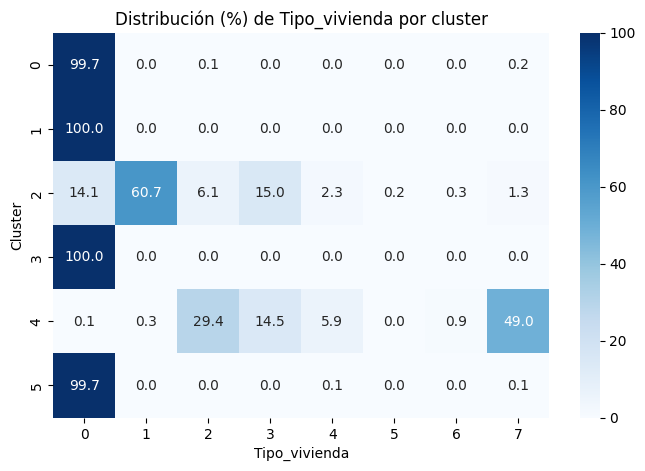

Operacion: Chi² = 9877.55, p = 0.0000, Cramér's V = 0.813


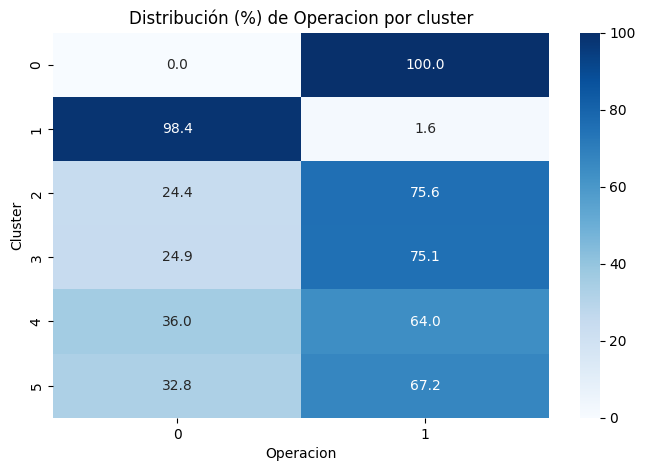

Garaje: Chi² = 3345.98, p = 0.0000, Cramér's V = 0.473


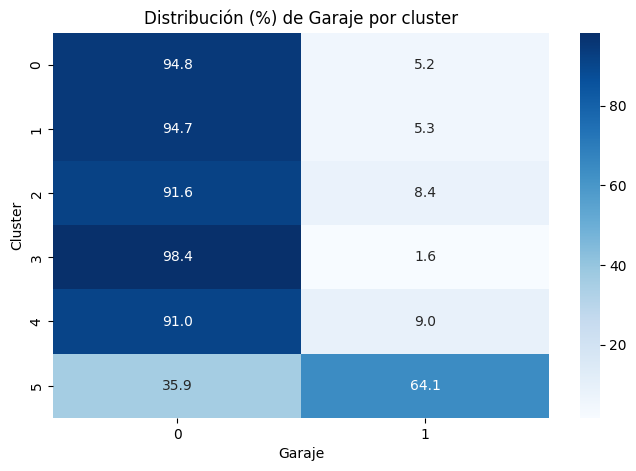

Trastero: Chi² = 12669.10, p = 0.0000, Cramér's V = 0.921


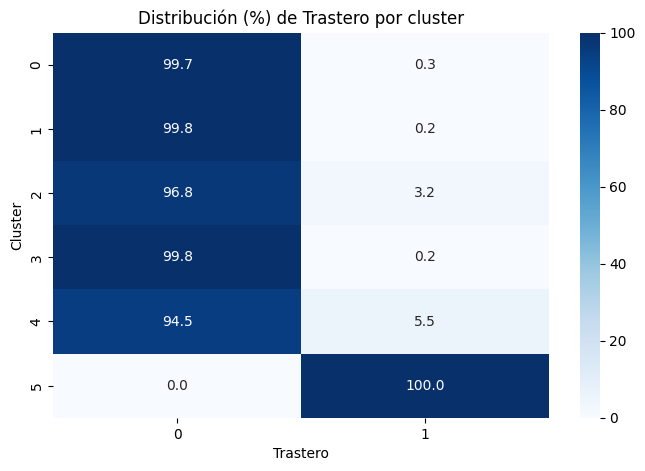

Piscina: Chi² = 805.34, p = 0.0000, Cramér's V = 0.231


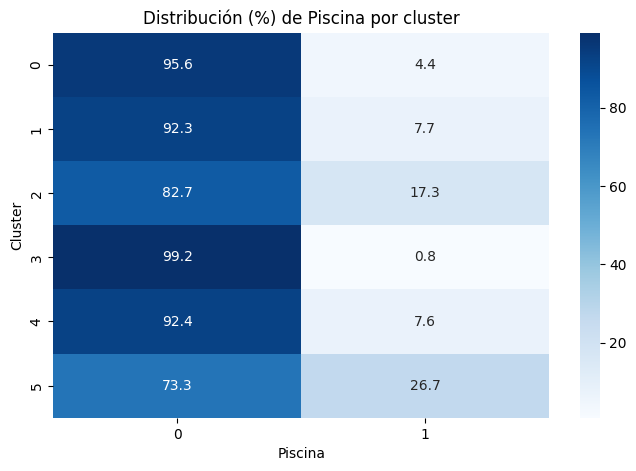

Terraza: Chi² = 536.56, p = 0.0000, Cramér's V = 0.189


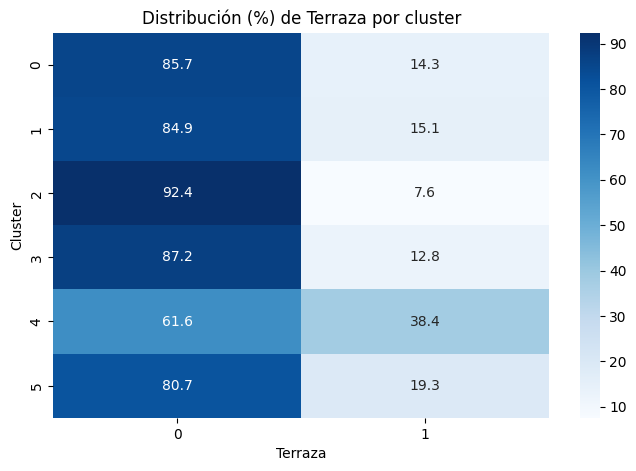

Exterior: Chi² = 2444.36, p = 0.0000, Cramér's V = 0.404


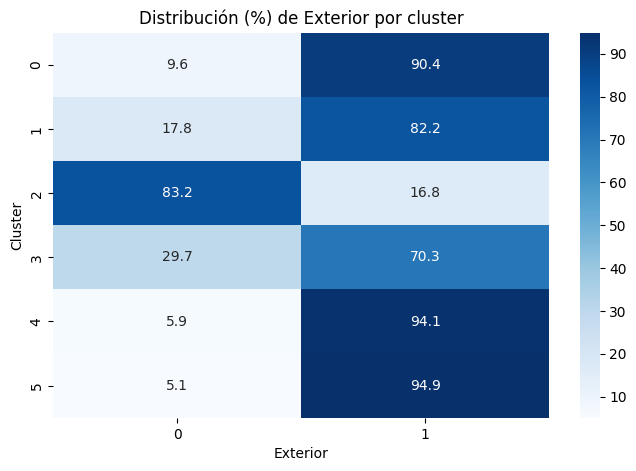

Ascensor: Chi² = 13352.27, p = 0.0000, Cramér's V = 0.945


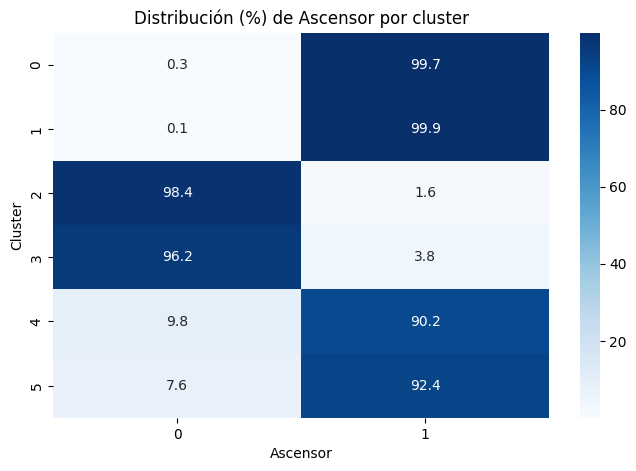

In [31]:
# 3. Cramér’s V para categóricas + heatmap

def cramers_v_corrected(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

print("\n=== Cramér's V y heatmaps ===")
for var in cat_vars:
    tabla = pd.crosstab(df[cluster_col], df[var])
    chi2, p, _, _ = stats.chi2_contingency(tabla)
    cv = cramers_v_corrected(tabla.values)
    print(f"{var}: Chi² = {chi2:.2f}, p = {p:.4f}, Cramér's V = {cv:.3f}")
    
    plt.figure(figsize=(8,5))
    sns.heatmap(tabla.div(tabla.sum(axis=1), axis=0)*100, cmap="Blues", annot=True, fmt=".1f")
    plt.title(f"Distribución (%) de {var} por cluster")
    plt.ylabel("Cluster")
    plt.xlabel(var)
    plt.show()

Tipo de Vivienda vs Cluster

Cramér’s V = 0.496 → Correlación moderada-alta entre el cluster y el tipo de vivienda.

Cluster 0 está muy diversificado en tipos de vivienda (varios valores con porcentajes intermedios).

Cluster 3 y 5 → 100% de un solo tipo → clusters muy especializados.

Cluster 1 y 2 → más del 95% concentrado en un solo tipo de vivienda → homogeneidad alta.

Conclusión: Algunos clusters se especializan en un tipo de vivienda concreto, mientras que otros agrupan tipologías más variadas.

2. Operación (Venta/Alquiler) vs Cluster

Cramér’s V = 0.168 → Correlación baja.

Hay clusters como Cluster 7 → 100% en una sola categoría (posiblemente venta).

Otros como Cluster 0 → 65% venta, 35% alquiler → mezcla moderada.

Conclusión:
El tipo de operación no es un gran diferenciador entre clusters, excepto en algunos muy concentrados.

3. Ascensor vs Cluster

Cramér’s V = 0.857 → Correlación muy alta.

Ejemplo:

Cluster 3 → 100% sin ascensor.

Cluster 5 y 6 → 100% con ascensor.

Otros clusters → mezclas variables.

Conclusión:

La presencia de ascensor es uno de los factores que más separa los clusters. Esto tiene sentido porque impacta mucho en el precio y el tipo de edificio.

4. Terraza vs Cluster

Cramér’s V = 0.210 → Correlación baja-moderada.

Cluster 0 → 37% con terraza → relativamente alto.

Cluster 4 y 2 → menos del 6% con terraza → muy bajo.

Conclusión:

La terraza influye un poco, pero no es el factor principal que define los clusters.

Resumen para el TFM

Ascensor es la variable categórica que más segmenta los clusters.

Tipo de vivienda también es importante, especialmente en clusters especializados.

Operación y Terraza tienen menos influencia, aunque algunos clusters muestran patrones claros.

Esto sugiere que las variables estructurales del edificio (ascensor, tipo) pesan más que variables como terraza o tipo de operación.

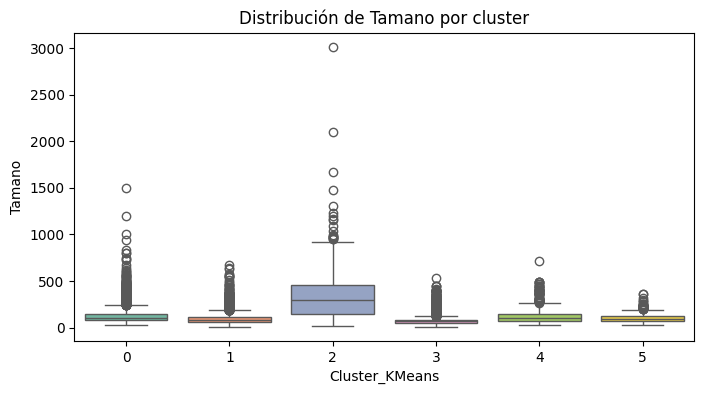

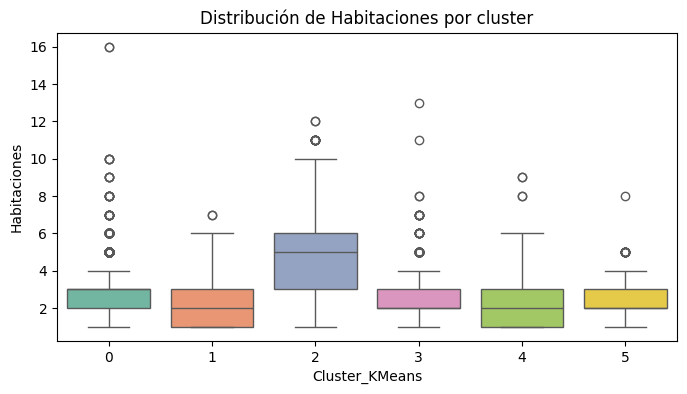

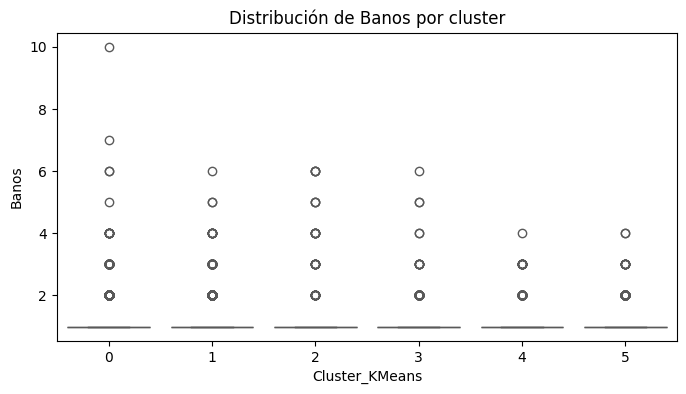

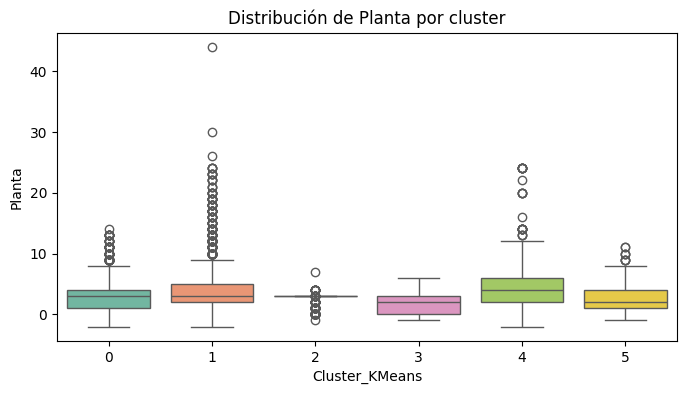

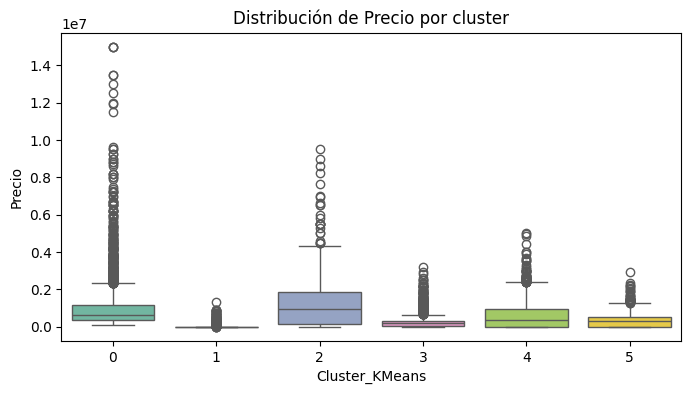

In [32]:
# 4. Boxplots para numéricas

for var in num_vars:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=cluster_col, y=var, data=df, palette="Set2", hue=cluster_col, legend=False)
    plt.title(f"Distribución de {var} por cluster")
    plt.show()


1. Precio ajustado por cluster

Clusters 4 y 7 → Median precios muy superiores al resto, pero con fuerte dispersión (outliers).

Cluster 7 → Claramente el segmento de viviendas de lujo/exclusivas.

Cluster 4 → Viviendas de alto precio, pero algo más heterogéneas.

Clusters 3 y 2 → Viviendas de bajo coste, precios muy concentrados y bajos.

Clusters 0, 1, 5, 6 → Segmentos intermedios, con cierta variabilidad.

Conclusión: El precio es una de las variables más discriminantes: algunos clusters son de lujo, otros de vivienda asequible.

2. Tamaño por cluster

Cluster 7 → Viviendas muy grandes (mediana > 900 m²), muy superior al resto → mansiones o edificios completos.

Cluster 4 → Viviendas grandes (mediana ≈ 340 m²).

Clusters 3 y 2 → Viviendas pequeñas (≈ 60–80 m²).

Clusters 0, 1, 5, 6 → Viviendas medianas (≈ 100–130 m²).

Conclusión: Tamaño y precio están correlacionados, pero con diferencias: hay clusters con viviendas grandes pero no necesariamente de lujo.

3. Habitaciones por cluster

Cluster 7 → Viviendas con mayor número de habitaciones (mediana > 6).

Cluster 4 → Viviendas con ≈ 5 habitaciones → segmento de clase media-alta.

Clusters 3 y 2 → Viviendas más pequeñas con 2 habitaciones de media.

Clusters 0, 1, 5, 6 → Segmentos intermedios (2–3 habitaciones).

Conclusión: Número de habitaciones sigue un patrón muy similar al tamaño → no sorprende dado que ambas están relacionadas con el tipo de vivienda.

Síntesis:

Cluster 7: Viviendas exclusivas, muy grandes y caras.

Cluster 4: Segmento premium pero más heterogéneo.

Clusters 3 y 2: Viviendas más asequibles, tamaño reducido.

Clusters 0, 1, 5, 6: Clusters intermedios, mezcla de precios y tamaños.

## Visualización 2D con UMAP

In [33]:
# Reducimos los embeddings a 2D
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_emb)

/home/jorge/master-data-science/TFM/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Guardar el umap

In [34]:
with open("../models/umap.pkl", "wb") as f:
    pickle.dump(reducer, f)

Cargar umap

In [35]:
with open("../models/umap.pkl", "rb") as f:
    reducer = pickle.load(f)

X_umap = reducer.transform(X_emb)

Mostrar gráfico

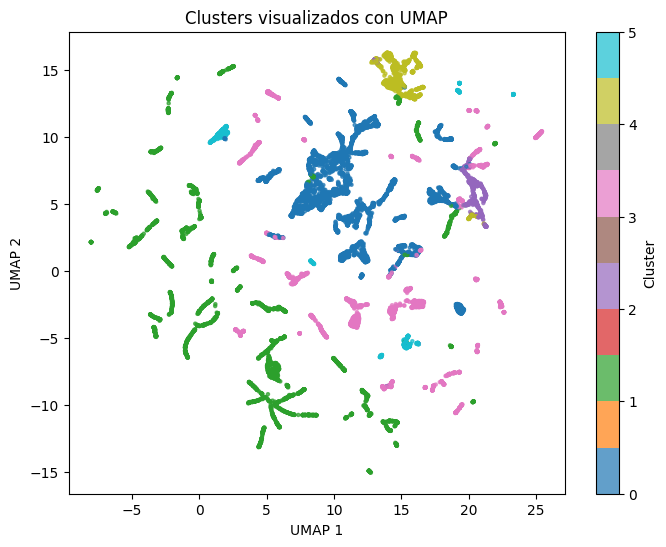

In [36]:
# Gráfico con colores por cluster
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df["Cluster_KMeans"], cmap="tab10", s=5, alpha=0.7)
plt.title("Clusters visualizados con UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter, label="Cluster")
plt.savefig("../reports/figures/umap.png", dpi=300)
plt.show()

1. Reducción de dimensionalidad

UMAP proyectó todas las variables originales (numéricas y categóricas transformadas) a un espacio bidimensional manteniendo las relaciones de vecindad entre viviendas.

Esto permite visualizar clusters complejos que en el espacio original de alta dimensión son imposibles de interpretar visualmente.

2. Validación de los clusters

En el gráfico, cada punto es una vivienda y el color representa el cluster KMeans asignado.

Observamos que:

Algunos clusters forman regiones bien diferenciadas, sobre todo los de precios altos y viviendas grandes.

Otros muestran solapamiento parcial, indicando que ciertas tipologías de vivienda son similares entre sí.

3. Patrones detectados

Clusters premium: Más concentrados y con poca dispersión → viviendas más homogéneas (alta renta, tamaño, ascensor).

Clusters intermedios: Más dispersos → viviendas con precios y características mixtas.

Clusters económicos: Presentan gran dispersión → variedad de viviendas en precio bajo y localizaciones múltiples.

## PERFILADO SOCIOECONOMICO POR CLUSTER

In [37]:
# Variables socioeconómicas
vars_socio = [
    "Renta_neta_persona", "Renta_neta_hogar", "Renta_bruta_persona",
    "Renta_bruta_hogar", "Edad_media", "Mayores_65anos%", "Menores_18anos%",
    "Paro_registrado%", "Apartamentos_turisticos", "Densidad_poblacion"
]

# Resumen por cluster
perfil_socio = df.groupby("Cluster_KMeans")[vars_socio].agg(["mean", "median"]).round(2)
print("=== Perfil socioeconómico por cluster ===")
print(perfil_socio)

KeyError: "Columns not found: 'Edad_media', 'Menores_18anos%', 'Renta_bruta_hogar', 'Mayores_65anos%', 'Densidad_poblacion', 'Paro_registrado%', 'Renta_bruta_persona', 'Renta_neta_persona', 'Renta_neta_hogar', 'Apartamentos_turisticos'"

1. Variables clave

Renta Neta y Bruta (persona y hogar):
→ Mide el poder adquisitivo.

Esperanza de vida, tamaño de vivienda, densidad poblacional (si se incluye):
→ Refleja condiciones de vida y urbanismo.

2. Patrones principales por cluster
Cluster 7 → Alta renta y viviendas premium

Renta neta persona: 23.339 €, la más alta.

Renta bruta persona: 31.296 €, la más alta.

Viviendas grandes y precios muy superiores al resto.

Corresponde probablemente a barrios de lujo (ej. Salamanca, Chamberí).

Cluster 4 → Clase media-alta consolidada

Renta neta persona: 20.672 €, también elevada.

Viviendas grandes pero con mayor dispersión en precios.

Barrios con buen nivel socioeconómico, pero no tan exclusivos como el cluster 7.

Clusters 0, 1, 2, 5 → Clase media

Rentas entre 19.000–20.000 €.

Viviendas de tamaño medio y precios moderados.

Probablemente zonas con equilibrio entre vivienda y renta.

Cluster 6 → Renta media-baja

Renta neta persona: 18.227 €, inferior al promedio.

Viviendas medianas, barrios más económicos.

Cluster 3 → Rentas bajas y viviendas pequeñas

Renta neta persona: 14.404 €, la más baja.

Viviendas pequeñas y precios muy inferiores.

Probablemente zonas de mayor vulnerabilidad socioeconómica.

3. Insights clave

Polarización clara:
Clusters 7 y 4 concentran la élite socioeconómica → precios, tamaño y renta mucho más altos.

Zonas intermedias (0,1,2,5):
Representan la clase media, viviendas estándar y precios moderados.

Cluster 3:
Claramente zonas desfavorecidas, tanto por tamaño como por renta.

Cluster 6:
Nivel medio-bajo, transición entre los más desfavorecidos y la clase media.

## EVOLUCION TEMPORAL DE LOS CLUSTERS

In [ ]:
# --- NADA de esto modifica df ---
tmp = df[["Ano", "Cluster_KMeans"]].copy()

tendencias = (
    tmp.groupby("Ano")["Cluster_KMeans"]
       .value_counts(normalize=True)     # proporción por año
       .mul(100)                         # a %
       .rename("Porcentaje")
       .reset_index()                    # columnas planas: Ano, Cluster_KMeans, Porcentaje
)

# Comprobación rápida
# display(tendencias.head())

# --- Gráfico de evolución temporal ---
plt.figure(figsize=(12,6))
for cluster in sorted(tendencias["Cluster_KMeans"].unique()):
    data_c = tendencias[tendencias["Cluster_KMeans"] == cluster]
    plt.plot(data_c["Ano"], data_c["Porcentaje"], marker="o", label=f"Cluster {cluster}")

plt.title("Evolución temporal de la distribución de clusters (%)")
plt.xlabel("Año")
plt.ylabel("Porcentaje (%)")
plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()